## Engineered Features and Modeling


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data
df_student_info = pd.read_csv('studentInfo.csv')

In [3]:
df_student_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
code_module             32593 non-null object
code_presentation       32593 non-null object
id_student              32593 non-null int64
gender                  32593 non-null object
region                  32593 non-null object
highest_education       32593 non-null object
imd_band                31482 non-null object
age_band                32593 non-null object
num_of_prev_attempts    32593 non-null int64
studied_credits         32593 non-null int64
disability              32593 non-null object
final_result            32593 non-null object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [4]:
# drop features
df_student_info =  df_student_info.drop(['id_student', 'imd_band'], axis=1)

In [5]:
## encode all the categorical values (less the target)
atts = ['region',"gender","age_band", 'code_module','highest_education','code_presentation','disability', 'num_of_prev_attempts','studied_credits']
dataRows = df_student_info.loc[:,atts]
for i,_ in enumerate(dataRows):
    df_student_info[atts[i]] = pd.factorize(df_student_info[atts[i]])[0]
df_student_info.head()

,code_module,code_presentation,gender,region,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,0,0,0,0,0,0,0,0,0,Pass
1,0,0,1,1,0,1,0,1,0,Pass
2,0,0,1,2,1,1,0,1,1,Withdrawn
3,0,0,1,3,1,1,0,1,0,Pass
4,0,0,1,4,2,2,0,1,0,Pass


In [6]:
df_student_info.nunique()

code_module              7
code_presentation        4
gender                   2
region                  13
highest_education        5
age_band                 3
num_of_prev_attempts     7
studied_credits         61
disability               2
final_result             4
dtype: int64

## _Feature Engineering :)_

- make dummy variables for each region
- make dummys for age_band

then see how logistic regression improves

- come up with some interaction terms (between dummy variables)
    - examples: gender/age, age/disability etc.
    
then try the model again

In [7]:
# making dummy for region
df_try = pd.get_dummies(df_student_info['region'])

In [8]:
df_try.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0


In [9]:
# concat
df_new = pd.concat([df_try, df_student_info], axis=1)
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,code_module,code_presentation,gender,region,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Pass
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,Pass
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,2,1,1,0,1,1,Withdrawn
3,0,0,0,1,0,0,0,0,0,0,...,0,0,1,3,1,1,0,1,0,Pass
4,0,0,0,0,1,0,0,0,0,0,...,0,0,1,4,2,2,0,1,0,Pass


In [10]:
# drop region
df_new =  df_new.drop(['region'], axis=1)

In [45]:
df_new.shape

(32593, 22)

In [46]:
df_new.columns

Index([                     0,                      1,                      2,
                            3,                      4,                      5,
                            6,                      7,                      8,
                            9,                     10,                     11,
                           12,          'code_module',    'code_presentation',
                     'gender',    'highest_education',             'age_band',
       'num_of_prev_attempts',      'studied_credits',           'disability',
               'final_result'],
      dtype='object')

In [29]:
# make dummy for age_band
df_dum = pd.get_dummies(df_new['age_band'])

In [30]:
df_dum.head()

,0,1,2
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1


In [31]:
# concat
df_super = pd.concat([df_new, df_dum], axis=1)


In [32]:
df_super.shape

(32593, 25)

In [33]:
df_super =  df_super.drop(['age_band'], axis=1)

In [34]:
df_super.shape

(32593, 24)

In [35]:
df_super.columns

Index([                     0,                      1,                      2,
                            3,                      4,                      5,
                            6,                      7,                      8,
                            9,                     10,                     11,
                           12,          'code_module',    'code_presentation',
                     'gender',    'highest_education', 'num_of_prev_attempts',
            'studied_credits',           'disability',         'final_result',
                            0,                      1,                      2],
      dtype='object')

In [36]:
df_super.final_result[2]

'Withdrawn'

In [37]:
# endoding target feature as binary 0 complete the course 1 drop
df_super.replace('Pass', 0,  inplace=True)
df_super.replace('Fail', 0 ,  inplace=True)
df_super.replace('Distinction', 0, inplace = True)
df_super.replace('Withdrawn', 1,  inplace=True)

In [38]:
df_super.head()

,0,1,2,3,4,5,6,7,8,9,...,code_presentation,gender,highest_education,num_of_prev_attempts,studied_credits,disability,final_result,0,1,2
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,2,0,1,0,0,0,0,1


## Logistic Regresion

In [39]:
x = df_super.drop(['final_result'], axis = 1)
y = df_super.loc[:,'final_result'] # Target

In [40]:
# slip the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [41]:
logisticRegr = LogisticRegression()


In [42]:
# training the model
logisticRegr.fit(X_train, Y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
pre = logisticRegr.predict(X_test)


In [44]:
score = logisticRegr.score(X_test, Y_test)
round_score = round(score , 2)
print(f'Accurance is {round_score}')

Accurance is 0.68


In [6]:
df_student_info.final_result.value_counts()

Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: final_result, dtype: int64

In [7]:
# endoding target feature as binary 0 complete the course 1 drop
df_student_info.replace('Pass', 0,  inplace=True)
df_student_info.replace('Fail', 0 ,  inplace=True)
df_student_info.replace('Distinction', 0, inplace = True)
df_student_info.replace('Withdrawn', 1,  inplace=True)

In [8]:
final = df_student_info.final_result.value_counts()
# drop 1
# pass 0

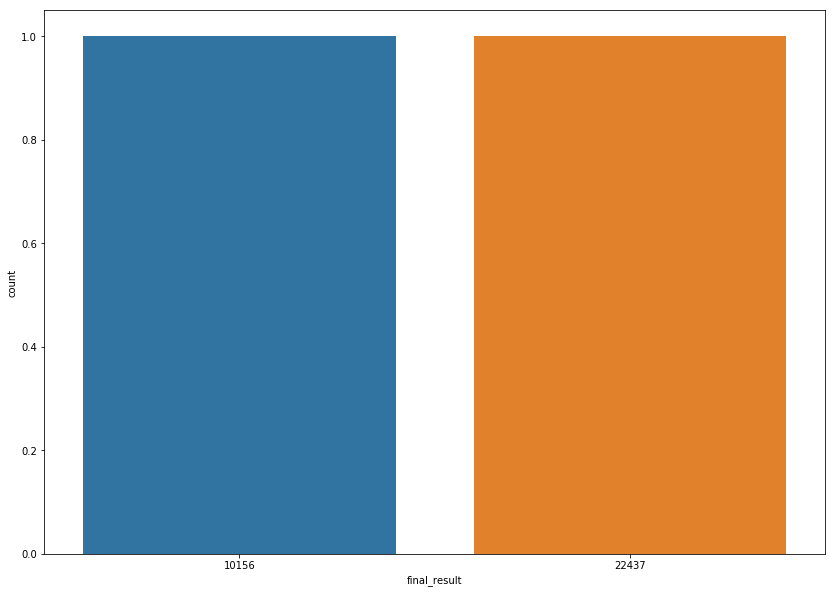

In [9]:
plt.figure(figsize=(14,10))
sns.countplot(final)

# Logistic Regresion

In [10]:
X = df_student_info.drop(['final_result'], axis = 1)
Y = df_student_info.loc[:,'final_result'] # Target


In [11]:
# selecting features for modeling
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
# 'gender' , 'highest_education , 'age_band' , 'disability',

Num Features: 4
Selected Features: [False False  True False  True  True False False  True]
Feature Ranking: [2 4 1 6 1 1 3 5 1]


In [12]:
# using selecting features for my model It didnt change much using selecting features
X_1 = df_student_info[['gender', 'highest_education', 'age_band' , 'disability',]]
# accurance 0.68

In [13]:
# slip the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [14]:
# cheking
x_train.shape


(26074, 9)

In [15]:
# create a model
logisticRegr = LogisticRegression()



In [16]:
# training the model
logisticRegr.fit(x_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
# make predictions
predictions = logisticRegr.predict(x_test)


In [16]:
# cheking for predictors
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
score = logisticRegr.score(x_test, y_test)
round_score = round(score , 2)
print(f'Accurance is {round_score}')

Accurance is 0.68


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

# my modeling precision is 56% for drop (1) students
# 70 % precesion for pass(0) studentes

#sensitivity actual true how sentitive is my test

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      4455
           1       0.55      0.01      0.02      2064

   micro avg       0.68      0.68      0.68      6519
   macro avg       0.62      0.50      0.41      6519
weighted avg       0.64      0.68      0.56      6519



In [20]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
# my model predict 4311 true negatives and 180 true possitives

[[4442   13]
 [2048   16]]


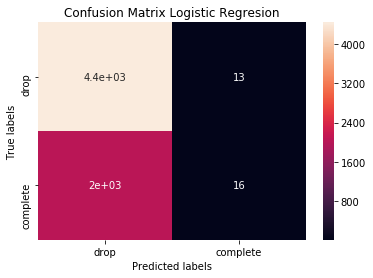

In [21]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Logistic Regresion'); 
ax.xaxis.set_ticklabels(['drop', 'complete']); ax.yaxis.set_ticklabels(['drop', 'complete']);

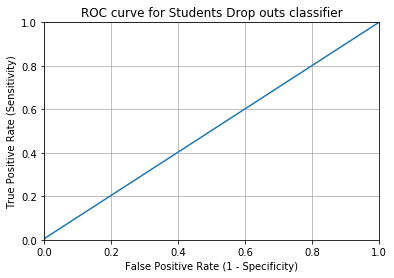

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Students Drop outs classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# KNN

- K = 5

In [23]:
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
print(knn)

#Train the model using the training sets
knn.fit(x_train, y_train)

#Predict the response for test dataset
y_pred_1 = knn.predict(x_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


In [24]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_1))

Accuracy: 0.657309403282712


In [25]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      4455
           1       0.44      0.29      0.35      2064

   micro avg       0.66      0.66      0.66      6519
   macro avg       0.58      0.56      0.56      6519
weighted avg       0.63      0.66      0.63      6519



In [26]:
cm_k_5 = confusion_matrix(y_test, y_pred_1)
cm_k_5
#[[3713  742]
# [1484  580]]

array([[3690,  765],
       [1469,  595]])

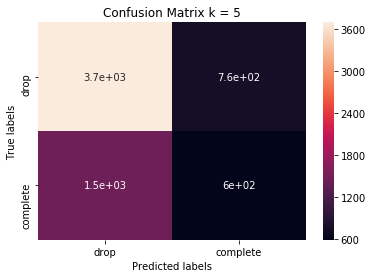

In [27]:
ax= plt.subplot()
sns.heatmap(cm_k_5, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix k = 5')
ax.xaxis.set_ticklabels(['drop', 'complete']); ax.yaxis.set_ticklabels(['drop', 'complete']);

- k = 3

In [28]:
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)
print(knn)

#Train the model using the training sets
knn.fit(x_train, y_train)

#Predict the response for test dataset
y_pred_3 = knn.predict(x_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')


In [29]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_3))

Accuracy: 0.6372142966712686


In [30]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      4455
           1       0.41      0.32      0.36      2064

   micro avg       0.64      0.64      0.64      6519
   macro avg       0.56      0.55      0.55      6519
weighted avg       0.62      0.64      0.62      6519



In [31]:
cm_k_3 = confusion_matrix(y_test, y_pred_3)
cm_k_3

array([[3488,  967],
       [1398,  666]])

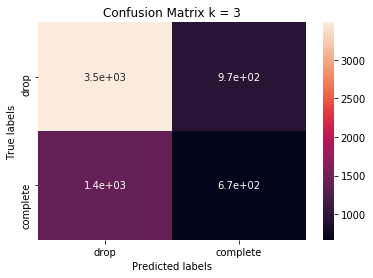

In [32]:
ax= plt.subplot()
sns.heatmap(cm_k_3, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix k = 3')
ax.xaxis.set_ticklabels(['drop', 'complete']); ax.yaxis.set_ticklabels(['drop', 'complete']);

- k = 7

In [33]:
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors = 7)
print(knn)

#Train the model using the training sets
knn.fit(x_train, y_train)

#Predict the response for test dataset
y_pred_7 = knn.predict(x_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')


In [34]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_7))

Accuracy: 0.661451142813315


In [35]:
print(classification_report(y_test, y_pred_7))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      4455
           1       0.44      0.27      0.33      2064

   micro avg       0.66      0.66      0.66      6519
   macro avg       0.58      0.56      0.55      6519
weighted avg       0.63      0.66      0.63      6519



In [36]:
cm_k_7 = confusion_matrix(y_test, y_pred_7)
cm_k_7
# miss clasificated 1513 and 551 out of???

array([[3758,  697],
       [1510,  554]])

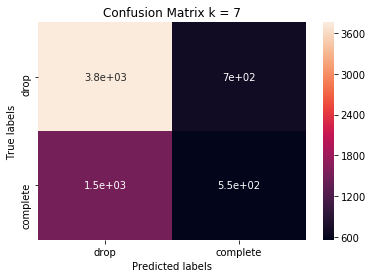

In [37]:
ax= plt.subplot()
sns.heatmap(cm_k_7, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix k = 7')
ax.xaxis.set_ticklabels(['drop', 'complete']); ax.yaxis.set_ticklabels(['drop', 'complete']);

# Decision Tree

In [38]:
classifier = DecisionTreeClassifier()
classifier.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
y_pred_c = classifier.predict(x_test)


In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_c))

Accuracy: 0.651787083908575


In [41]:
print(classification_report(y_test, y_pred_c))

              precision    recall  f1-score   support

           0       0.71      0.83      0.76      4455
           1       0.42      0.28      0.33      2064

   micro avg       0.65      0.65      0.65      6519
   macro avg       0.57      0.55      0.55      6519
weighted avg       0.62      0.65      0.63      6519



In [42]:
cm_c = confusion_matrix(y_test, y_pred_c)
cm_c

array([[3678,  777],
       [1493,  571]])

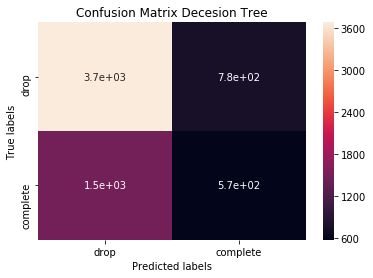

In [43]:
ax= plt.subplot()
sns.heatmap(cm_c, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix Decesion Tree')
ax.xaxis.set_ticklabels(['drop', 'complete']); ax.yaxis.set_ticklabels(['drop', 'complete']);

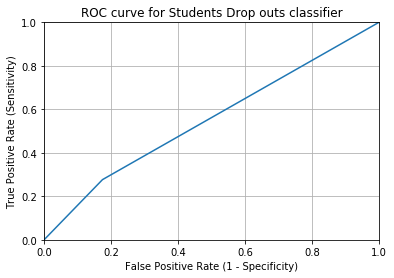

In [44]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_c)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Students Drop outs classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=20)



In [46]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
x_test_reshape = x_test.values.reshape(-1,1)

In [48]:
x_test_reshape.shape

(58671, 1)

In [49]:
y_pred_r = clf.predict(x_test)

In [50]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_r))


Accuracy: 0.6488725264611137


In [51]:
cm_r = confusion_matrix(y_test, y_pred_r)
cm_r

array([[3634,  821],
       [1468,  596]])

In [52]:
print(classification_report(y_test,y_pred_r))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      4455
           1       0.42      0.29      0.34      2064

   micro avg       0.65      0.65      0.65      6519
   macro avg       0.57      0.55      0.55      6519
weighted avg       0.62      0.65      0.63      6519



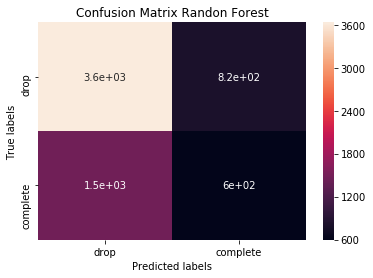

In [53]:
ax= plt.subplot()
sns.heatmap(cm_r, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix Randon Forest')
ax.xaxis.set_ticklabels(['drop', 'complete']); ax.yaxis.set_ticklabels(['drop', 'complete']);

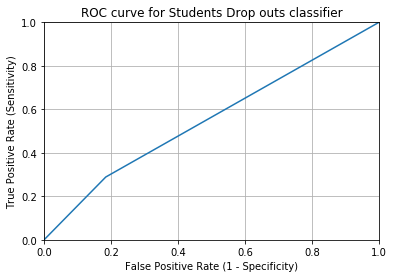

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_r)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Students Drop outs classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## SVC

In [ ]:
svclassifier = SVC(kernel='poly')
svclassifier.fit(x_train, y_train)

In [ ]:
y_pred_svc = svclassifier.predict(x_test)


In [56]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svc))


Accuracy: 0.5993250498542722


In [ ]:
print(classification_report(y_test,y_pred_svc))

In [ ]:
cm_svc = confusion_matrix(y_test, y_pred_svc)


In [ ]:
ax= plt.subplot()
sns.heatmap(cm_svc, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix SVC')
ax.xaxis.set_ticklabels(['drop', 'complete']); ax.yaxis.set_ticklabels(['drop', 'complete']);

In [ ]:
greatserach for randorm forest 
gradiendant bootsting
trying diffrernt kerneedl for

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(x_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=2,
              max_features=2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [56]:
predictions = gb_clf2.predict(x_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[4390   65]
 [1937  127]]
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      4455
           1       0.66      0.06      0.11      2064

   micro avg       0.69      0.69      0.69      6519
   macro avg       0.68      0.52      0.46      6519
weighted avg       0.68      0.69      0.59      6519



In [57]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions))


Accuracy: 0.6928976836938181


In [58]:
cm_gb= confusion_matrix(y_test, predictions)
cm_gb

array([[4390,   65],
       [1937,  127]])

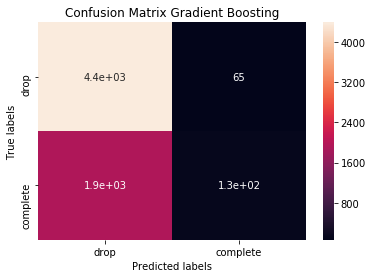

In [59]:
ax= plt.subplot()
sns.heatmap(cm_gb, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix Gradient Boosting')
ax.xaxis.set_ticklabels(['drop', 'complete']); ax.yaxis.set_ticklabels(['drop', 'complete']);